In [1]:
# UNCOMMENT first with internet option turned on
# Use GPU env

# !pip download tabpfn --no-deps -d pip-packages

# from tabpfn import TabPFNClassifier
# TabPFNClassifier(N_ensemble_configurations = 64, device = 'cuda:0')

# !mv /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt pip-packages/
# !zip -r pip-packages.zip pip-packages

# now you need to download the zip and upload it as dataset with the plus in the top left
# then you need to add it to the notebook as data on the right, and name it `pip-packages-icr`

# now you can turn internet off and still install, like below

In [2]:
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

In [3]:
# !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

# Welcome!

Thank you for viewing my submission for this competition! I have tried to make it as easy to follow as possible. If you have any questions, please feel free to ask in the comments section.

My notebook is broken up into the following sections:

### 1. Data Preprocessing

In this section I do simple steps to clean the data and impute missing values. I also join in data from the `greeks_df` to add the `Epsilon` feature along with getting the `Alpha` field which further classifies the values in the `Class` field in our training data.

### 2. Alpha Prediction Features

The first step of my prediction pipeline is create a set of predictions on my training set for the `Alpha` field from the `greeks_df`. When I train the models in this section I only use a subset of all the features in the training dataset. I found that using only a subset of features improve the performance of later models, likely because later models were overfitting on the predictions from the intial models.

I use a KNN, SVM, Extra Trees, and TabPFN model in this section. I chose these models as they are all very different approaches to building and training a predictive model and the hope is that their predictions each tell future models something different about a paticular row. 

Side note: "Alpha" has a dual purpose here as this is the first set of predictions (alpha predictions) in the model pipeline and the models are trying to predict each rows class in the `Alpha` column (alpha predictions). For the first reason, I hope I can get this "Alpha Prediction Features" term to catch on within the community :)

### 3. Boosting Predictions

The models that are handeling the final predictions are two gradient boosting models, `XGBoostClassifier` and `CatBoostClassifier`. In my testing, these models out performed others at this task, specificially in terms of the `competition_log_loss` which is how submissions for this competition are being evaluated. Without doing a simple copy and paste, I haven't been able to match the best scoring notebooks in this competition, but the 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyprojroot import here

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer

# import base estimators
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

### Data Pull

In [55]:
# load data
local_dir = str(here()) + '/'
kaggle_dir = '/kaggle/input/'
train_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/greeks.csv')

# join greeks and add Epsilon
train_df = pd.merge(train_df, greeks_df, on = 'Id')
train_df = train_df.drop(['Beta', 'Gamma', 'Delta'], axis = 1)
train_df['Epsilon'] = train_df['Epsilon'].replace('Unknown', np.nan)

# dropping rows with missing values in Epsilon as it helps with class imbalance
# if future data does have this column, it will be important to know if it is missing
train_df = train_df[train_df['Epsilon'].isna() == False].copy()
train_df['Epsilon'] = pd.to_datetime(train_df['Epsilon'])

# change epsilon to months since 1-1-2019 when data started to pick up
train_df['Days Since 1-1-2019'] = (train_df['Epsilon'] - pd.to_datetime('2019-01-01')).dt.days
train_df = train_df.drop('Epsilon', axis = 1)
train_df.reset_index(drop = True, inplace = True)

In [56]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

In [57]:
# features tiered by importance
tier_1_features = ['EP', 'CR', 'AY', 'AB', 'DU', 'DA', 'DI', 'DH', 'BC', 'DL', 'EE', 'BQ', 'Months Since 1-1-2019']
tier_2_features = ['EG', 'DY', 'FD ', 'AX', 'FR', 'FC', 'EL', 'DE', 'EU', 'FI', 'CS', 'BN', 'EH', 'EB', 'CC', 'GL', 'FL', 'CU', 'AF']
tier_3_features = ['AH', 'AM', 'AR', 'AZ', 'BD ', 'BP', 'BR', 'BZ', 'CB', 'CD ', 'CF', 'CH', 'CL', 'CW ', 'DF', 'DN', 'DV', 'EJ', 'FE', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI']

# Data Preprocessing

In [58]:
# set random seed
random_seed = 101010
np.random.seed(random_seed)

# pre-process data
y_alpha = train_df['Alpha']
y_class = train_df['Class']
x = train_df.drop(['Id', 'Alpha', 'Class'], axis = 1, inplace = False)

# create x and y train
X_train = x.copy()
y_train_alpha = y_alpha.copy()
alpha_encoder = LabelEncoder()
y_train_alpha = alpha_encoder.fit_transform(y_train_alpha)
y_train_class = y_class.copy()

# scale and impute data
X_train['EJ'].replace({'A': 0, 'B': 1}, inplace = True)
X_train_columns = X_train.columns
X_train_index = X_train.index
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
knn_imputer = KNNImputer()
X_train = knn_imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = X_train_columns, index = X_train_index)

# Alpha Prediction Features

In this section I am using a KNN, SVM, Extra Trees, and TabPFN to create a set of alpha prediction features to be used in my final models. Each of these models uses differing approaches in making predictions, and the goal is for each to provide a unique insight about how to make predictions on the data.

I am using a stratified k fold that splits the data into k different sets (folds) to complete this step. Alpha prediction features for fold 1 are created by training a model on fold 2, 3, 4, and 5. Predictions for fold 2 we train a model on fold 1, 3, 4, 5. Repeat until we have alpha predictions for the whole dataset. This ensures our alpha models are not trained and fitted on the same data as this would cause overfitting in later models that use these predictions as features.

The `fit_alpha_model()` function is created to simplify the code for this process. Built into that function is a prediction normalization step that helps reduce log loss for this competition.

The last step is creating the features `Alpha_0`, `Alpha_1`, `Alpha_2`, and `Alpha_3` which are the average of the predictions from from the Extra Trees and TabPFN models.

In [59]:
def fit_alpha_model(model_name, model, X_train, y_train, X_test, features):
    """
    Function to fit a model and generate prediction probabilities for each class.
    This is used for fitting alpha models whose predictions are used as features for the later models.
    
    Args:
        model_name (str): Name of the model.
        model (object): Scikit-learn like model to be fitted.
        X_train (DataFrame): DataFrame with the training features.
        y_train (Series): Series with the training target.
        X_test (DataFrame): DataFrame with the testing features.
        features (list): List of feature column names.
        
    Returns:
        predictions_df (DataFrame): DataFrame with prediction probabilities for each class.
    """
    
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    if model_name == 'TabPFN':
        model.fit(X, y, overwrite_warning = True)
    else:
        model.fit(X, y)
        
    model_predictions = model.predict_proba(test)
    class_0 = model_predictions[:, 0].sum()
    class_123 = model_predictions[:, 1:].sum()
    
    # normalize probabilities
    new_probabilities = model_predictions * np.array([[1/(class_0 if i == 0 else class_123) for i in range(model_predictions.shape[1])]])
    model_predictions = new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1) 
    
    # create a dataframe with predictions
    predictions_df = pd.DataFrame(model_predictions, columns = model.classes_, index = X_test.index)
    predictions_df.columns = ['_'.join([model_name, str(col)]) for col in predictions_df.columns]
    
    return predictions_df


In [60]:
# fitting alpha models
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
model_prediction_features_df = pd.DataFrame({})

model_features = [
    'DU', 'CR', 'AB', 'DA', 'DH', 'BC', 'FR', 'EP', 'DI', 'FL', 'EU', 'EH', 'Days Since 1-1-2019'
]

for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_alpha[train_index], y_train_alpha[test_index]
    
    # KNN
    knn_features = model_features[0:3]
    knn_features.append(model_features[-1])
    knn = KNeighborsClassifier(n_neighbors = 7)
    knn_predictions = fit_alpha_model('KNN 7', knn, fold, fold_y, oof, knn_features)
    
    # SVM
    svm = SVC(probability = True, random_state = random_seed)
    svm_predictions = fit_alpha_model('SVM', svm, fold, fold_y, oof, model_features)
    
    # Extra Trees
    extra_trees = ExtraTreesClassifier(n_estimators = 250, random_state = random_seed)
    extra_trees_predictions = fit_alpha_model('Extra Trees', extra_trees, fold, fold_y, oof, model_features)
    
    # TabPFN
    tabpfn = TabPFNClassifier(N_ensemble_configurations = 64, seed = random_seed)
    tabpfn_predictions = fit_alpha_model('TabPFN', tabpfn, fold, fold_y, oof, model_features)
    
    predictions_df = pd.concat([knn_predictions, extra_trees_predictions, svm_predictions, tabpfn_predictions], axis = 1)
    model_prediction_features_df = pd.concat([model_prediction_features_df, predictions_df])

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [61]:
X_train_alpha_models, y_train_alpha_models = RandomOverSampler(random_state = random_seed).fit_resample(X_train, y_train_alpha)

alpha_models = {
    'KNN 7': knn.fit(X_train_alpha_models[knn_features], y_train_alpha_models),
    'SVM': svm.fit(X_train_alpha_models[model_features], y_train_alpha_models),
    'Extra Trees': extra_trees.fit(X_train_alpha_models[model_features], y_train_alpha_models),
    'TabPFN': tabpfn.fit(X_train_alpha_models[model_features], y_train_alpha_models, overwrite_warning = True)
}

In [62]:
X_train = pd.concat([X_train, model_prediction_features_df], axis = 1)
for pred_class in y_train_alpha:
    X_train['Alpha_' + str(pred_class)] = (X_train['TabPFN_' + str(pred_class)] + X_train['Extra Trees_' + str(pred_class)]) / 2

In [63]:
print('Shape of X:', X_train.shape)
print('Shape of y:', y_train_alpha.shape)

Shape of X: (473, 77)
Shape of y: (473,)


In [64]:
# print('Shape of X:', X_test.shape)
# print('Shape of y:', y_test.shape)

# Boosting Predictions

In [65]:
def competition_log_loss(y_true, y_pred):
    """
        Computes the competition log loss.

        This function computes the log loss for a binary classification problem, 
        but it averages the log loss for each class separately and then takes their mean.
        It is used when we want to give equal attention to both classes.

        Parameters:
        y_true (np.array): True labels.
        y_pred (np.array): Predicted probabilities.

        Returns:
        float: The competition log loss.
    """
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = 1 - proba_1
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

### XGBoost

In [66]:
xgb = XGBClassifier(random_state = random_seed)

parameters = {
    'booster': ['gbtree'],
    'learning_rate': [0.02],
    'n_estimators': [300],
    'max_depth': [6],
    'gamma': [0.3],
    'min_child_weight': [2],
    'max_delta_step': [1],
    'subsample': [0.7],
    'base_score': [0.85],
    'n_jobs': [-1]
}

grid_obj = GridSearchCV(xgb, parameters, scoring = balanced_log_loss_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train_class)
xgb = grid_obj.best_estimator_
xgb.fit(X_train, y_train_class)

XGBClassifier(base_score=0.85, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=6, max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, predictor=None, random_state=101010, ...)

In [67]:
# view results
xgb_results = pd.DataFrame(grid_obj.cv_results_)
print('Balanced Log Loss:', np.round(xgb_results['mean_test_score'].max() * -1, 4))

Balanced Log Loss: 0.226


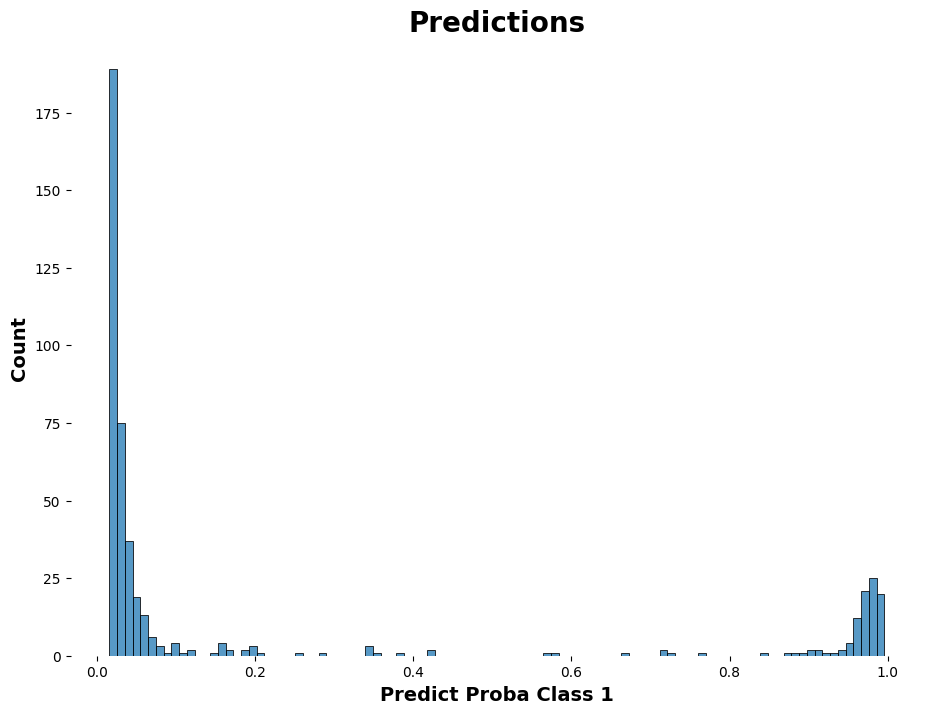

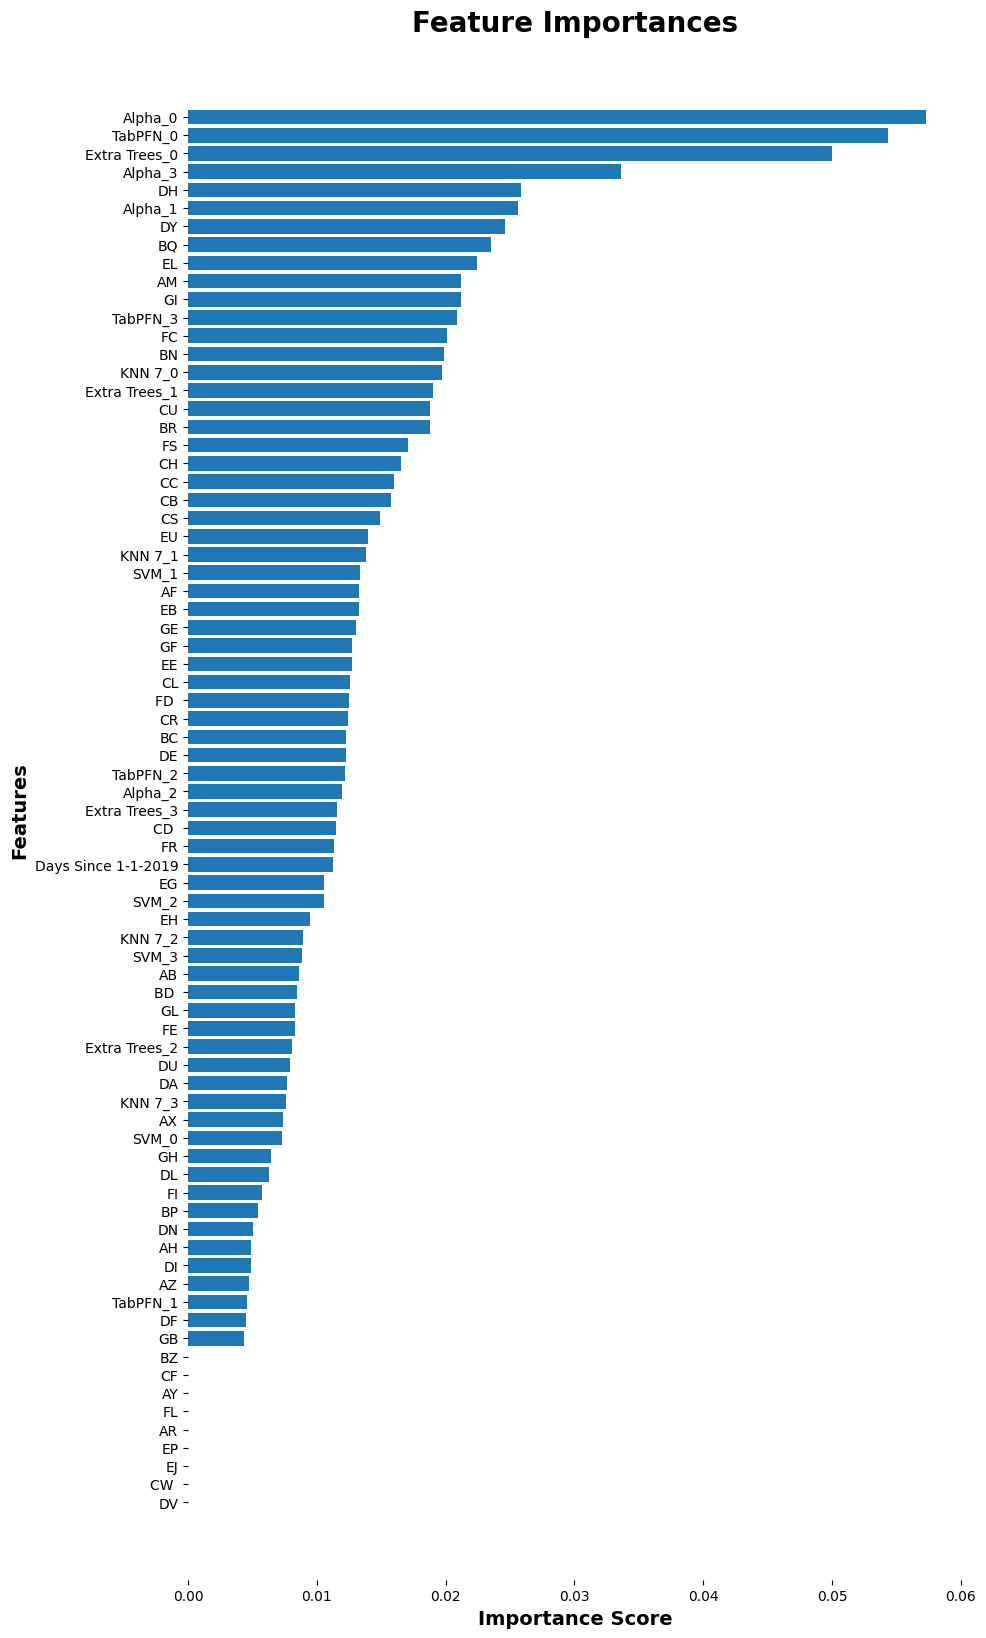

In [68]:
# plot histogram of y_train_pred
y_train_pred = xgb.predict_proba(X_train)[:,1]

plt.figure(figsize = (11, 8))
plt.title('Predictions', fontdict = font_dict_header)
sns.histplot(y_train_pred, bins = 100, kde = False)
plt.box(False)
plt.xlabel('Predict Proba Class 1', fontdict = font_dict_axistitle)
plt.ylabel('Count', fontdict = font_dict_axistitle)
plt.box(False)
plt.show()

# plot feature importances
importances = pd.Series(xgb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

## Cat Boost

In [69]:
catboost = CatBoostClassifier(random_state = random_seed, verbose = False)

parameters = {
    'learning_rate': [0.03],
    'iterations': [300],
    'depth': [9],
    'random_strength': [0.3],
    'border_count': [4],
    'bagging_temperature': [0.9],
    'loss_function': ['Logloss']
    
}

grid_obj = GridSearchCV(catboost, parameters, scoring = balanced_log_loss_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train, y_train_class)
catboost = grid_obj.best_estimator_
catboost.fit(X_train, y_train_class)

In [70]:
# view results
catboost_results = pd.DataFrame(grid_obj.cv_results_)
print('Balanced Log Loss:', np.round(catboost_results['mean_test_score'].max() * -1, 4))

Balanced Log Loss: 0.2606


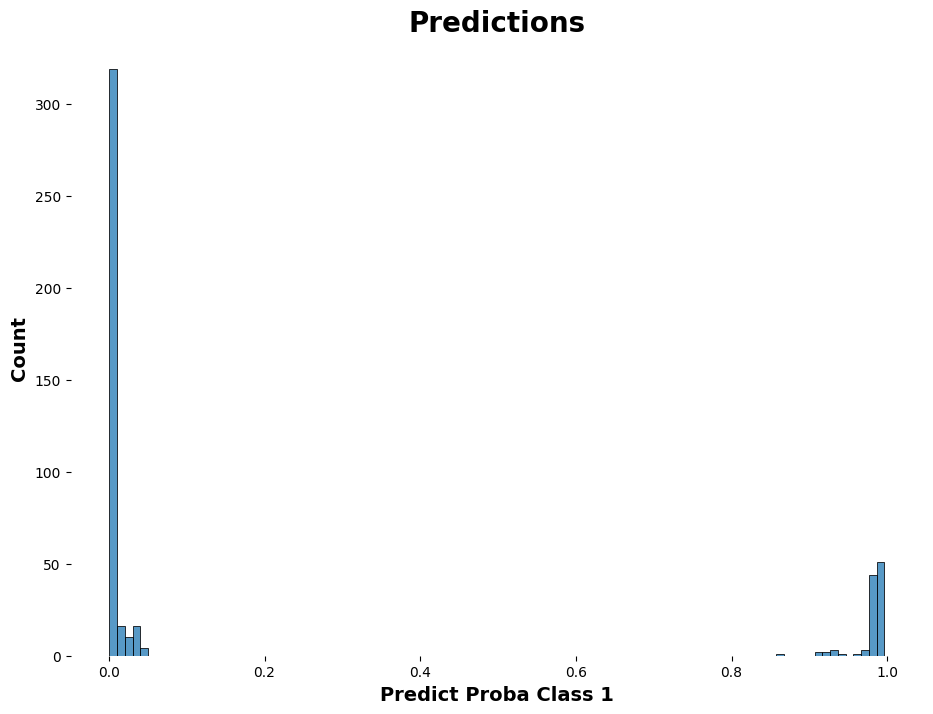

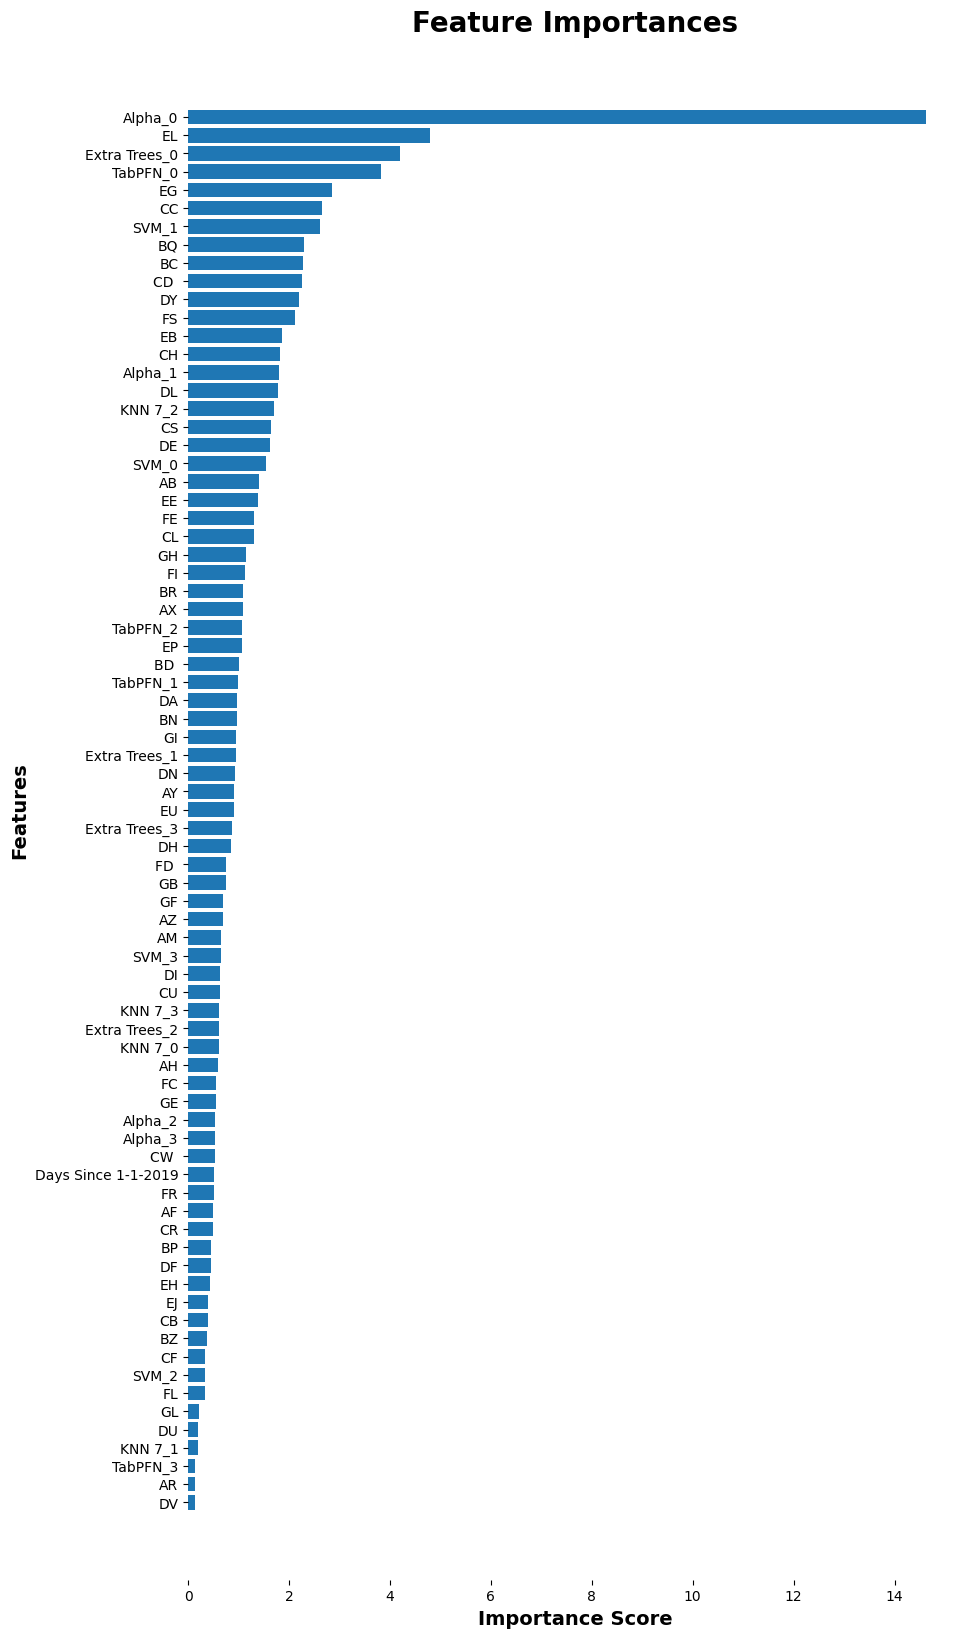

In [71]:
# plot histogram of y_train_pred
y_train_pred = catboost.predict_proba(X_train)[:,1]

plt.figure(figsize = (11, 8))
plt.title('Predictions', fontdict = font_dict_header)
sns.histplot(y_train_pred, bins = 100, kde = False)
plt.box(False)
plt.xlabel('Predict Proba Class 1', fontdict = font_dict_axistitle)
plt.ylabel('Count', fontdict = font_dict_axistitle)
plt.box(False)
plt.show()

# plot feature importances
importances = pd.Series(catboost.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

### Test Sampling Strategies

In [72]:
def model_cross_validation(X, y, models, model_names, n_splits = 5):
    skf = StratifiedKFold(n_splits = n_splits, random_state = random_seed, shuffle = True)
    
    # create dataframe to hold results
    results_df = pd.DataFrame(columns = ['Model', 'Fold', 'Accuracy', 'ROC AUC', 'Log Loss'])
    
    for sampling_strategy in ['None', 'SMOTE', 'RandomOverSampler']:
        print('----------------------------------')
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            if sampling_strategy == 'SMOTE':
                X_train, y_train = SMOTE(random_state = random_seed).fit_resample(X_train, y_train)
            elif sampling_strategy == 'RandomOverSampler':
                X_train, y_train = RandomOverSampler(random_state = random_seed).fit_resample(X_train, y_train)
            else:
                pass
            
            model_predictions = {}
            for model, model_name in zip(models, model_names):
                if sampling_strategy == 'None':
                    model_name = model_name
                else:
                    model_name = model_name + ' with ' + sampling_strategy
                
                print(model_name, 'Fold', i + 1)
                if str.startswith(model_name, 'TabPFN'):
                    model.fit(X_train[X_train_columns[:-16]], y_train)
                    y_pred = model.predict(X_test[X_train_columns[:-16]])
                    
                    y_proba = model.predict_proba(X_test[X_train_columns[:-16]])
                    y_proba_class_0 = y_proba[:,0].sum()
                    y_proba_class_1 = y_proba[:,1].sum()
                    new_probabilities = y_proba * np.array([[1/(y_proba_class_0 if i==0 else y_proba_class_1) for i in range(y_proba.shape[1])]])
                    y_proba = new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
                    
                    y_proba = y_proba[:, 1]
                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    
                    y_proba = model.predict_proba(X_test)
                    y_proba_class_0 = y_proba[:,0].sum()
                    y_proba_class_1 = y_proba[:,1].sum()
                    new_probabilities = y_proba * np.array([[1/(y_proba_class_0 if i==0 else y_proba_class_1) for i in range(y_proba.shape[1])]])
                    y_proba = new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
                    
                    y_proba = y_proba[:, 1]
                
                fold_accuracy = accuracy_score(y_test, y_pred)
                fold_roc_auc = roc_auc_score(y_test, y_proba)
                fold_log_loss = competition_log_loss(y_test, y_proba)
                
                new_result_index = len(results_df)
                new_results_row = pd.DataFrame({
                    'Model': model_name, 
                    'Fold': i + 1, 
                    'Accuracy': fold_accuracy, 
                    'ROC AUC': fold_roc_auc,
                    'Log Loss': fold_log_loss
                }, index = [new_result_index])
                
                results_df = pd.concat([results_df, new_results_row])
                model_predictions[str(model_name) + '_proba'] = y_proba.tolist()
                
            # average predictions
            if sampling_strategy == 'None':
                model_name = 'Average'
            else:
                model_name = 'Average' + ' with ' + sampling_strategy
            
            
            weighted_proba = []
            for prediction in model_predictions:
                if str.startswith(prediction, 'XGBoost'):
                    weighted_proba.append(np.array(model_predictions[prediction]) * 0.7)
                elif str.startswith(prediction, 'CatBoost'):
                    weighted_proba.append(np.array(model_predictions[prediction]) * 0.3)
                else:
                    weighted_proba.append(np.array(model_predictions[prediction]) * 0)
            
            y_proba = np.sum(weighted_proba, axis = 0)
            y_pred = np.where(y_proba > 0.5, 1, 0)
            fold_accuracy = accuracy_score(y_test, y_pred)
            fold_roc_auc = roc_auc_score(y_test, y_proba)
            fold_log_loss = competition_log_loss(y_test, y_proba)
            
            new_result_index = len(results_df)
            new_results_row = pd.DataFrame({
                'Model': model_name, 
                'Fold': i + 1, 
                'Accuracy': fold_accuracy, 
                'ROC AUC': fold_roc_auc,
                'Log Loss': fold_log_loss
            }, index = [new_result_index])
            
            results_df = pd.concat([results_df, new_results_row])
        
    return results_df

In [73]:
models = [xgb, catboost]
model_names = ['XGBoost', 'CatBoost']

In [74]:
cv_results = model_cross_validation(X_train, y_train_class, models, model_names)

----------------------------------
XGBoost Fold 1
CatBoost Fold 1
XGBoost Fold 2
CatBoost Fold 2
XGBoost Fold 3
CatBoost Fold 3
XGBoost Fold 4
CatBoost Fold 4
XGBoost Fold 5
CatBoost Fold 5
----------------------------------
XGBoost with SMOTE Fold 1
CatBoost with SMOTE Fold 1
XGBoost with SMOTE Fold 2
CatBoost with SMOTE Fold 2
XGBoost with SMOTE Fold 3
CatBoost with SMOTE Fold 3
XGBoost with SMOTE Fold 4
CatBoost with SMOTE Fold 4
XGBoost with SMOTE Fold 5
CatBoost with SMOTE Fold 5
----------------------------------
XGBoost with RandomOverSampler Fold 1
CatBoost with RandomOverSampler Fold 1
XGBoost with RandomOverSampler Fold 2
CatBoost with RandomOverSampler Fold 2
XGBoost with RandomOverSampler Fold 3
CatBoost with RandomOverSampler Fold 3
XGBoost with RandomOverSampler Fold 4
CatBoost with RandomOverSampler Fold 4
XGBoost with RandomOverSampler Fold 5
CatBoost with RandomOverSampler Fold 5


In [76]:
# find best sampling strategy for submission
results = cv_results.drop('Fold', axis = 1).groupby('Model').mean()
results['Accuracy Z Score'] = (results['Accuracy'] - results['Accuracy'].mean()) / results['Accuracy'].std()
results['ROC AUC Z Score'] = (results['ROC AUC'] - results['ROC AUC'].mean()) / results['ROC AUC'].std()
results['Log Loss Z Score'] = ((results['Log Loss'] - results['Log Loss'].mean()) / results['Log Loss'].std()) * -1
results['Average Z Score'] = results[['ROC AUC Z Score','Log Loss Z Score']].mean(axis = 1)
results.sort_values('Log Loss Z Score', ascending = False)

,Accuracy,ROC AUC,Log Loss,Accuracy Z Score,ROC AUC Z Score,Log Loss Z Score,Average Z Score
Model,,,,,,,
Average with SMOTE,0.932318,0.978124,0.196625,-1.066070,1.292621,0.920593,1.106607
Average,0.936529,0.977578,0.196732,-0.667266,1.109571,0.911286,1.010429
Average with RandomOverSampler,0.938656,0.974115,0.197803,-0.465743,-0.052395,0.818235,0.382920
XGBoost with SMOTE,0.949205,0.977863,0.198670,0.533389,1.205075,0.742981,0.974028
CatBoost,0.949183,0.971417,0.208065,0.531267,-0.957693,-0.073178,-0.515435
XGBoost with RandomOverSampler,0.955521,0.971867,0.208132,1.131595,-0.806479,-0.078979,-0.442729
XGBoost,0.955588,0.972680,0.208205,1.137959,-0.533894,-0.085308,-0.309601
CatBoost with RandomOverSampler,0.949183,0.970290,0.222777,0.531267,-1.335730,-1.351249,-1.343490
CatBoost with SMOTE,0.925980,0.974506,0.227993,-1.666398,0.078923,-1.804382,-0.862729


### Submission

In [393]:
def prediction_pipeline(X):
    X['EJ'].replace({'A': 0, 'B': 1}, inplace = True)
    X = X.select_dtypes(include = [np.number])
    X['Days Since 1-1-2019'] = [X_train['Days Since 1-1-2019'].max() + 1] * len(X)
    
    X_columns = X.columns
    X_index = X.index
    
    X = standard_scaler.transform(X)
    X = knn_imputer.transform(X)
    X = pd.DataFrame(X, columns = X_columns, index = X_index)

    for model in alpha_models:
        if model == 'KNN 7':
            model_predictions = alpha_models[model].predict_proba(X[knn_features])
        else:
            model_predictions = alpha_models[model].predict_proba(X[model_features])
            
        predictions_df = pd.DataFrame(model_predictions, columns = alpha_models[model].classes_, index = X_index)        
        predictions_df.columns = [model + '_' + str(col) for col in predictions_df.columns]
        X = pd.concat([X, predictions_df], axis = 1)
        
    for pred_class in y_train_alpha:
        X['Alpha_' + str(pred_class)] = X['Extra Trees_' + str(pred_class)] + X['TabPFN_' + str(pred_class)]
    
    model_train, model_y = RandomOverSampler(random_state = random_seed).fit_resample(X_train, y_train_class)
    
    models = {'XGBoost': {'model': xgb, 'weight': 0.7},
              'CatBoost': {'model': catboost, 'weight': 0.3}}

    weighted_proba = []
    
    for model_name, model_info in models.items():
        model_info['model'].fit(model_train, model_y)
        prediction = model_info['model'].predict_proba(X)
        class_0 = prediction[:,0].sum()
        class_1 = prediction[:,1].sum()
        probabilities = prediction * np.array([[1/(class_0 if i==0 else class_1) for i in range(prediction.shape[1])]])
        proba = probabilities / np.sum(probabilities, axis = 1, keepdims = 1)
        proba = proba[:, 1]
        
        weighted_proba.append(proba * model_info['weight'])

    X['class_1'] = np.sum(weighted_proba, axis = 0)
    X['class_0'] = 1 - X['class_1']
        
    return X

In [394]:
X_test = prediction_pipeline(test_df)

In [395]:
predictions = X_test[['class_0', 'class_1']]
submission = pd.concat([test_df[['Id']], predictions], axis = 1)
submission.to_csv('submission.csv', index = False)

In [396]:
submission

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5
